In [1]:
import os, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial import KDTree, QhullError
from scipy.stats import truncnorm
from scipy.interpolate import LinearNDInterpolator, griddata

In [2]:
import numpyro
from numpyro.handlers import seed, substitute, trace
from jax import random
from celestify.numpyro_models import HierarchicalStarModel

2024-02-07 11:17:35.191870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 11:17:35.191900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 11:17:35.192901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 11:17:35.779578: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


Save the truths as a json file.

In [3]:
directory = "/mnt/data-storage/alexlyttle/scalable-stellar-inference"

with open(os.path.join(directory, "truths.json"), "r") as file:
    s = file.read()
    truths = json.loads(s)

In [4]:
filename = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/dataset.h5"
train = pd.read_hdf(filename, "train").reset_index(drop=True)
train.head()

,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,radius,...,log_g,log_L,delta_X,f_nuc,phase,EEP,bol_mag,abs_G,abs_BP,abs_RP
0,7000,5,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.259691e+07,0.894573,...,4.500174,0.074879,0.001608,1.002145,0,0.000000,4.562802,4.547648,4.770715,4.160442
1,7000,6,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.548000e+07,0.895385,...,4.499387,0.075651,0.001875,1.001741,0,0.000427,4.560872,4.545704,4.768774,4.158500
2,7000,7,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,4.309136e+07,0.896934,...,4.497885,0.077058,0.002592,1.001313,0,0.001206,4.557356,4.542152,4.765255,4.154919
3,7000,8,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,5.405171e+07,0.898494,...,4.496376,0.078459,0.003644,1.000889,0,0.001982,4.553852,4.538610,4.761750,4.151341
4,7000,9,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,6.983463e+07,0.900101,...,4.494823,0.079984,0.005195,1.000489,0,0.002826,4.550040,4.534769,4.757914,4.147505


In [5]:
test = pd.read_hdf(filename, "test").sample(frac=1).reset_index(drop=True)
test.head()

,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,radius,...,log_g,log_L,delta_X,f_nuc,phase,EEP,bol_mag,abs_G,abs_BP,abs_RP
0,6957,1026,2.04829,0.299623,0.029798,1.805133,0.015597,0.006041,1.187296e+09,5.110310,...,3.332565,1.284857,0.670579,1.144894,0,0.421185,1.537858,1.474021,1.879221,0.911276
1,4738,490,1.99399,0.232119,0.008208,2.642877,0.015332,0.006041,1.024753e+09,2.675882,...,3.882857,1.530953,0.759663,1.099663,0,0.172392,0.922617,0.941272,0.982578,0.865767
2,120,55,0.97241,0.232967,0.007363,2.650140,0.000000,0.006041,4.131757e+09,0.937468,...,4.482004,0.024908,0.340741,0.999848,0,0.064316,4.687729,4.618720,4.887836,4.183480
3,7363,132,1.16235,0.226479,0.010519,2.361578,0.000000,0.006041,5.597865e+09,1.474336,...,4.166211,0.465846,0.762308,1.000089,0,0.152122,3.585386,3.500685,3.750342,3.091324
4,7124,261,1.40454,0.316420,0.005885,1.307477,0.004542,0.006041,1.430513e+09,1.752742,...,4.098166,1.129747,0.675850,0.941154,0,0.175946,1.925632,1.937953,1.992788,1.834888


In [6]:
input_cols = ["EEP", "star_mass", "M_H", "Yinit", "amlt"]
output_cols = ["star_age", "Teff", "radius", "Dnu_freq_o"]

In [51]:
train_tracks = train.set_index("track").loc[:, input_cols[1:]].drop_duplicates()
train_tracks

,star_mass,M_H,Yinit,amlt
track,,,,
7000,0.92329,-0.852135,0.279311,1.608258
7002,2.12329,-0.477134,0.304311,2.658258
7003,1.32329,0.272866,0.254311,1.958258
7006,1.52329,-0.664635,0.316811,1.783258
7007,0.72329,0.085366,0.266811,2.483258
...,...,...,...,...
4995,1.19087,-0.074669,0.304189,2.448737
4996,1.39087,-0.637168,0.241689,1.573737
4997,2.19087,0.112831,0.291689,2.273737


In [52]:
sorted_inputs = {k: v.sort_values() for k, v in train_tracks[input_cols[1:]].items()}

In [53]:
a = set()
# a = a.union(sorted_inputs["star_mass"].iloc[10-1:10+2].index)
# a.union([5600, 7800])
a = sorted_inputs["star_mass"].iloc[10-1:10+2].index

In [54]:
len(train_tracks)

6849

In [55]:
train_inputs = train[input_cols].to_numpy()
train_outputs = train[output_cols].to_numpy()

In [56]:
test_inputs = test[input_cols].to_numpy()
test_outputs = test[output_cols].to_numpy()

In [57]:
tracks = train.groupby("track")

In [58]:
stars_per_track = tracks["star"].count()

In [59]:
track0 = tracks.get_group(0)

In [62]:
num_test = 10
num_tracks = len(train_tracks)
interp_values = np.full((num_test, len(output_cols)), np.nan)

for i in range(num_test):
    point = test.iloc[i]
    indices = []
    for key, value in sorted_inputs.items():
        diff = point[key] - value
        abs_diff = diff.abs()
        mid_j = abs_diff.argmin()
        for j in range(max(0, mid_j-1), min(mid_j+2, num_tracks)):
            # for each track, pick out EEP
            track_id = value.index[j]
            if track_id in indices:
                # Ensure we don't include duplicate tracks
                continue
            track = tracks.get_group(track_id)
            k = (point["EEP"] - track["EEP"]).abs().argmin()
            mask = slice(max(0, k-1), min(k+2, stars_per_track.loc[track_id]))
            indices += track.iloc[mask].index.to_list()
        # sign = diff.iloc[j]/abs_diff.iloc[j]  # if +1, point lies above value, if -1 point lies below value
        # indices = indices.union(value.iloc[slice(max(0, j-1), min(j+2, num_tracks))].index)
    
    # isin = train.track.isin(indices)
    # cross_section = train.loc[isin].sort_values("EEP")
    interp_values[i] = griddata(train_inputs[indices], train_outputs[indices], point[input_cols])

In [71]:
diff = (point[input_cols[1:]] - train_tracks)**2

In [75]:
diff.sum(axis=1).sort_values().index[]

track
1149    0.003707
557     0.005039
205     0.006203
6189    0.006466
4717    0.006869
          ...   
3040    4.148693
7328    4.192770
8080    4.251345
800     4.330493
4960    4.343968
Length: 6849, dtype: float64

In [66]:
train_inputs[indices]

array([[ 0.17877866,  1.99214   , -0.05351984,  0.25627014,  2.065155  ],
       [ 0.17914105,  1.99214   , -0.05351984,  0.25627014,  2.065155  ],
       [ 0.1795113 ,  1.99214   , -0.05351984,  0.25627014,  2.065155  ],
       [ 0.17890023,  1.99253   , -0.89470569,  0.29765198,  2.213153  ],
       [ 0.17930987,  1.99253   , -0.89470569,  0.29765198,  2.213153  ],
       [ 0.17972026,  1.99253   , -0.89470569,  0.29765198,  2.213153  ],
       [ 0.17852295,  1.99282   , -0.54378458,  0.27916443,  1.442145  ],
       [ 0.17891275,  1.99282   , -0.54378458,  0.27916443,  1.442145  ],
       [ 0.17938198,  1.99282   , -0.54378458,  0.27916443,  1.442145  ],
       [ 0.17842397,  0.96362   ,  0.29840878,  0.29145081,  1.698407  ],
       [ 0.17913999,  0.96362   ,  0.29840878,  0.29145081,  1.698407  ],
       [ 0.17984565,  0.96362   ,  0.29840878,  0.29145081,  1.698407  ],
       [ 0.17874347,  2.06792   ,  0.298775  ,  0.22292053,  1.460175  ],
       [ 0.17928585,  2.06792   ,  0.2

In [63]:
interp_values

array([[           nan,            nan,            nan,            nan],
       [           nan,            nan,            nan,            nan],
       [1.24508712e+09, 8.86599297e+03, 1.81885971e+00, 6.54478076e+01],
       [           nan,            nan,            nan,            nan],
       [           nan,            nan,            nan,            nan],
       [           nan,            nan,            nan,            nan],
       [           nan,            nan,            nan,            nan],
       [           nan,            nan,            nan,            nan],
       [           nan,            nan,            nan,            nan],
       [           nan,            nan,            nan,            nan]])

In [99]:
cross_section

,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,radius,...,log_g,log_L,delta_X,f_nuc,phase,EEP,bol_mag,abs_G,abs_BP,abs_RP
488775,7742,4,1.58970,0.275063,0.008730,2.270660,0.009533,0.006041,3.427975e+07,1.324049,...,4.395575,0.927930,0.007523,1.000085,0,0.000000,2.430174,2.464607,2.511193,2.374865
1079858,626,2,2.06948,0.289815,0.007589,1.379510,0.015682,0.006041,7.150832e+06,1.408899,...,4.456169,1.438632,0.001532,1.000195,0,0.000000,1.153420,1.663753,1.625662,1.720548
1199254,809,4,1.84761,0.306417,0.027902,2.492401,0.014158,0.006041,3.288468e+07,1.638184,...,4.275952,1.033264,0.007243,1.000224,0,0.000000,2.166840,2.115283,2.185893,1.983746
2171588,2100,3,1.49214,0.262520,0.003988,1.802655,0.006947,0.006041,1.945546e+07,1.187035,...,4.462950,0.886018,0.003548,0.999623,0,0.000000,2.534955,2.626048,2.659308,2.560477
2293332,2293,248,2.25776,0.261544,0.030536,1.378827,0.016139,0.006041,2.205549e+07,1.825356,...,4.269050,1.273531,0.005001,1.000143,0,0.000000,1.566173,1.603459,1.629370,1.554819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4425845,6625,565,1.50142,0.306459,0.039378,1.966461,0.007202,0.006041,3.546391e+09,15.962550,...,2.208365,1.862026,0.654163,0.994709,0,0.995365,0.094935,0.406013,1.128328,-0.398598
2172455,2100,870,1.49214,0.262520,0.003988,1.802655,0.006947,0.006041,1.858328e+09,15.912779,...,2.208385,2.022683,0.733491,0.993711,0,0.995414,-0.306707,-0.177635,0.353332,-0.852305
1199986,809,736,1.84761,0.306417,0.027902,2.492401,0.014158,0.006041,1.487233e+09,17.725755,...,2.207468,2.114563,0.665681,0.993351,0,0.995429,-0.536406,-0.423298,0.147776,-1.122149
489557,7742,786,1.58970,0.275063,0.008730,2.270660,0.009533,0.006041,1.768027e+09,16.564266,...,2.201038,2.099354,0.716207,0.994024,0,0.997724,-0.498386,-0.416983,0.096564,-1.075716


In [136]:
loc = train_tracks.min(0).to_numpy()
scale = train_tracks.max(0).to_numpy() - loc
scale[0] *= 1/5

tree = KDTree((train_tracks - loc) / scale)
# tree = KDTree(train[input_cols])

In [137]:
num_neigbours = 10
num_test = 20

x_scaled = (test[input_cols[1:]].iloc[:num_test] - loc) / scale
distances, indices = tree.query(x_scaled, num_neigbours)

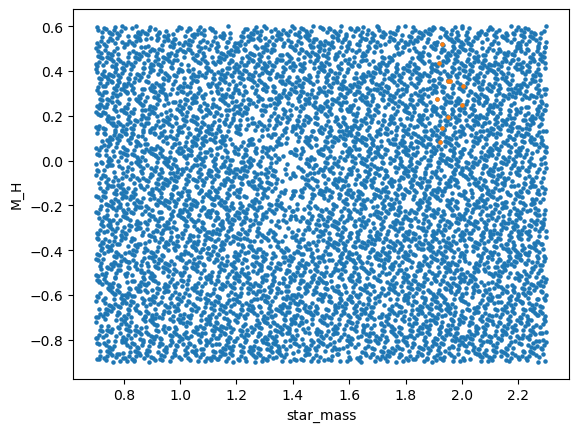

In [140]:
ax = train_tracks.plot(x="star_mass", y="M_H", kind="scatter", marker=".")
train_tracks.iloc[indices[0]].plot(x="star_mass", y="M_H", kind="scatter", marker=".", ax=ax, color="C1");

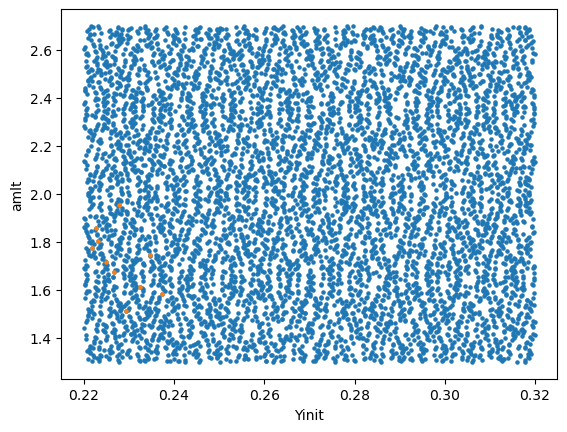

In [141]:
ax = train_tracks.plot(x="Yinit", y="amlt", kind="scatter", marker=".")
train_tracks.iloc[indices[0]].plot(x="Yinit", y="amlt", kind="scatter", marker=".", ax=ax, color="C1");

In [142]:
num_points = 10
num_floor = num_points//2
num_remain = num_points%2
interp_values = np.full((num_test, len(output_cols)), np.nan)

for i in range(num_test):
    isin = train.track.isin(train_tracks.iloc[indices[i]].index)
    cross_section = train.loc[isin].sort_values("EEP")

    idx = []
    for _, group in cross_section.groupby("track"):
        argmin = (group["EEP"] - test["EEP"].iloc[i]).abs().argmin()
        mask = slice(
            max(0, argmin - num_floor), 
            min(argmin + num_floor + num_remain, len(group))
        )
        idx += group.iloc[mask].index.to_list()
    
    # argmin = (cross_section["EEP"] - test["EEP"].iloc[i]).abs().argmin()

    # mask = slice(
    #     max(0, argmin - num_floor), 
    #     min(argmin + num_floor + num_remain, len(cross_section))
    # )
    # idx = cross_section.iloc[mask].index

    interp_values[i] = griddata(train_inputs[idx], train_outputs[idx], test_inputs[i])

In [143]:
interp_values

array([[2.03550929e+09, 4.57323134e+03, 7.00750468e+00, 1.12123114e+01],
       [           nan,            nan,            nan,            nan],
       [           nan,            nan,            nan,            nan],
       [1.80619781e+09, 4.98632445e+03, 4.08179106e+00, 2.21730644e+01],
       [           nan,            nan,            nan,            nan],
       [           nan,            nan,            nan,            nan],
       [           nan,            nan,            nan,            nan],
       [6.91323603e+08, 6.76531676e+03, 6.30805031e+00, 1.25728794e+01],
       [1.19125696e+09, 7.44492529e+03, 3.33888540e+00, 3.08879759e+01],
       [           nan,            nan,            nan,            nan],
       [           nan,            nan,            nan,            nan],
       [1.31724944e+09, 4.56526800e+03, 1.56913461e+01, 2.86560626e+00],
       [3.07816507e+08, 1.03597900e+04, 1.53752419e+00, 8.68874760e+01],
       [2.09819288e+09, 7.09602985e+03, 1.76840987e

In [144]:
np.nanstd(test_outputs - interp_values, axis=0)

array([5.48734323e+06, 1.17767510e+02, 6.54218197e-01, 1.87146615e+00])

In [108]:
cross_section.iloc[argmin+50]["EEP"]

0.5690780093395336

In [35]:
train.loc[train.track.isin(train_tracks.iloc[indices[i]].index)]

,index,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,...,log_g,log_L,delta_X,f_nuc,phase,EEP,bol_mag,abs_G,abs_BP,abs_RP
988341,1196280,488,2,1.00073,0.305831,0.004522,2.084979,0.0,0.006041,6.803270e+07,...,4.452645,0.211210,0.006492,0.999968,0,0.000000,4.221974,4.175962,4.381052,3.817025
988342,1196281,488,3,1.00073,0.305831,0.004522,2.084979,0.0,0.006041,9.229422e+07,...,4.451006,0.213194,0.009525,0.999912,0,0.001059,4.217016,4.171005,4.375957,3.812272
988343,1196282,488,4,1.00073,0.305831,0.004522,2.084979,0.0,0.006041,1.272308e+08,...,4.449023,0.215675,0.013903,0.999875,0,0.002385,4.210813,4.164813,4.369566,3.806369
988344,1196283,488,5,1.00073,0.305831,0.004522,2.084979,0.0,0.006041,1.500984e+08,...,4.447841,0.217188,0.016777,0.999862,0,0.003193,4.207031,4.161041,4.365663,3.802787
988345,1196284,488,6,1.00073,0.305831,0.004522,2.084979,0.0,0.006041,1.775395e+08,...,4.446485,0.218941,0.020233,0.999850,0,0.004130,4.202648,4.156672,4.361136,3.798646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5258969,6516556,4912,499,0.89712,0.303017,0.003945,1.896393,0.0,0.006041,8.270356e+09,...,2.213697,1.801610,0.693038,0.992566,0,0.986866,0.245976,0.369880,0.897705,-0.302237
5258970,6516557,4912,500,0.89712,0.303017,0.003945,1.896393,0.0,0.006041,8.271006e+09,...,2.218681,1.797744,0.693038,0.992323,0,0.988923,0.255640,0.378543,0.905539,-0.292942
5258971,6516558,4912,501,0.89712,0.303017,0.003945,1.896393,0.0,0.006041,8.274645e+09,...,2.215692,1.801054,0.693038,0.994108,0,0.990680,0.247366,0.369964,0.896769,-0.301367
5258972,6516559,4912,502,0.89712,0.303017,0.003945,1.896393,0.0,0.006041,8.274905e+09,...,2.210806,1.805046,0.693038,0.994562,0,0.992802,0.237384,0.360780,0.888256,-0.311061


In [ ]:
for i, index in enumerate(indices):
    
    try:
        interp_values[i] = griddata(train_inputs[index], train_outputs[index], test_inputs[i])
    except QhullError:
        continue

In [7]:
data = pd.concat([train, test], axis=0, ignore_index=True)

In [62]:
test_inputs = test[input_cols].to_numpy()
test_outputs = test[output_cols].to_numpy()

In [40]:
# loc = train[input_cols].mean(0).to_numpy()
# scale = train[input_cols].std(0).to_numpy()

loc = train[input_cols].min(0).to_numpy()
scale = train[input_cols].max(0).to_numpy() - loc
scale[0] *= 1e-3  # make EEP distances larger
# scale[1] *= 1e-1

tree = KDTree((train[input_cols] - loc) / scale)
# tree = KDTree(train[input_cols])

In [83]:
num_neigbours = 100
num_test = 10

x_scaled = (test_inputs[:num_test] - loc) / scale
distances, indices = tree.query(x_scaled, num_neigbours)

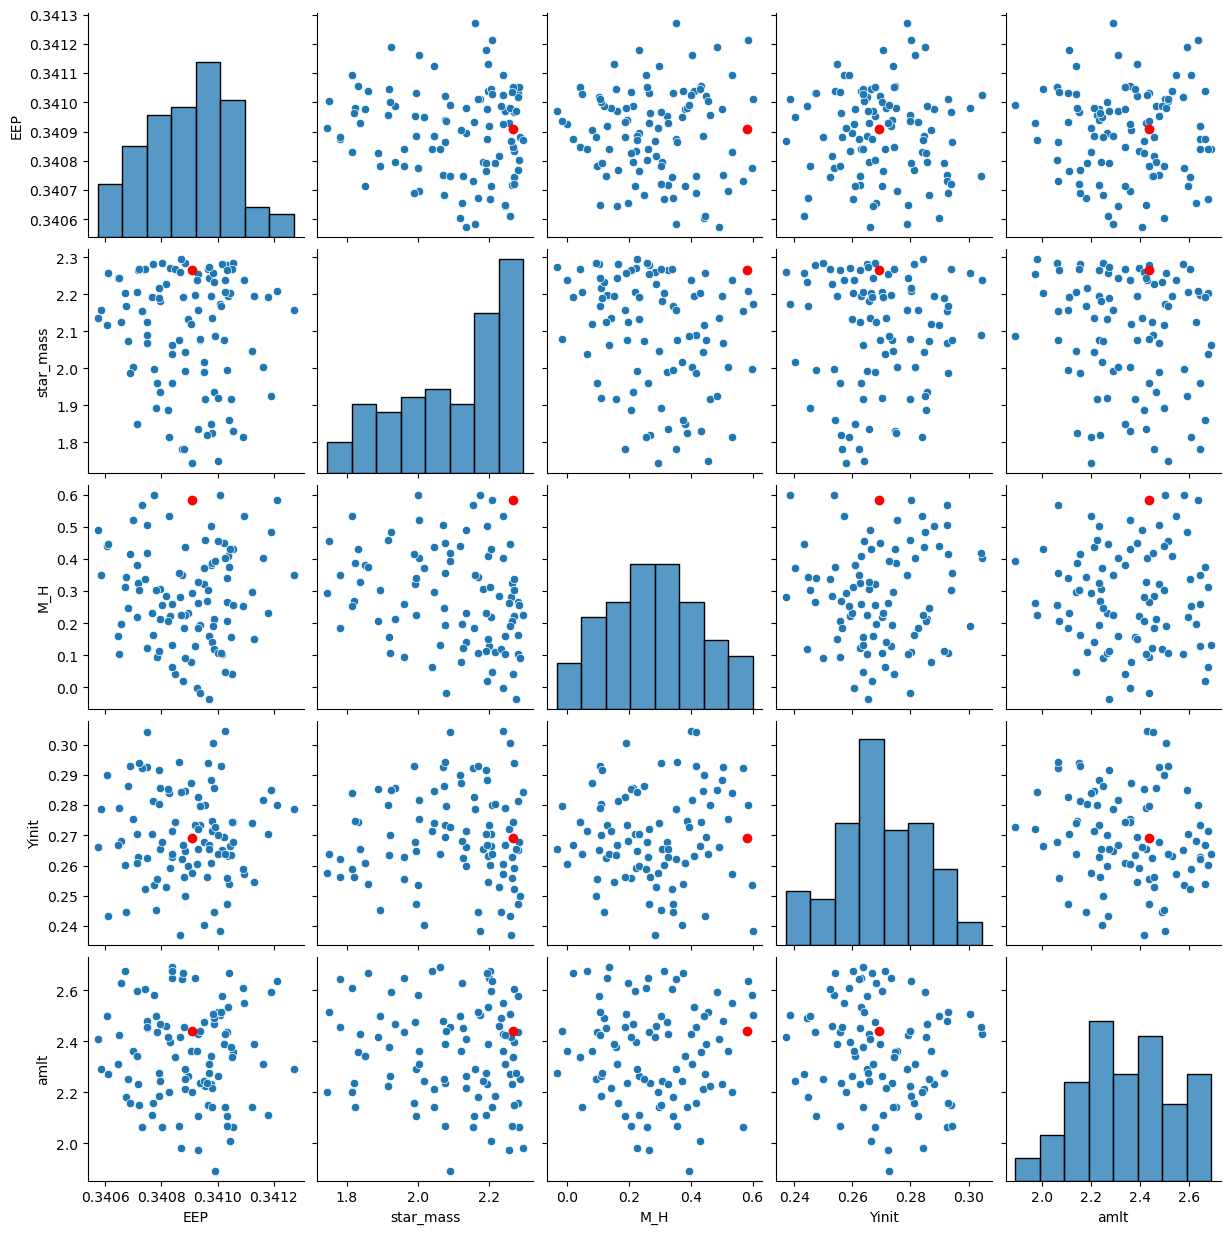

In [84]:
i = 9
pairgrid = sns.pairplot(train.iloc[indices[i]], vars=input_cols);

n = len(input_cols)
for j, ax in enumerate(pairgrid.axes.ravel()):
    if j//n == j%n:
        continue
    ax.plot(test_inputs[i][j%n], test_inputs[i][j//n], "ro")

In [85]:
interp_values = np.full((num_test, len(output_cols)), np.nan)
train_inputs = train[input_cols].to_numpy()
train_outputs = train[output_cols].to_numpy()

In [86]:
for i, index in enumerate(indices):
    try:
        interp_values[i] = griddata(train_inputs[index], train_outputs[index], test_inputs[i])
    except QhullError:
        continue

In [87]:
np.isnan(interp_values).all(1).sum()

2

In [88]:
test_outputs[:num_test] - interp_values

array([[-1.46538658e+07, -2.72881031e+00, -5.65036055e-02,
        -1.36374359e-01],
       [-1.03971259e+07,  6.93479552e+01, -4.53984573e-02,
         3.87365572e-01],
       [-9.65357857e+08,  4.79202110e+01, -1.39471988e-02,
        -6.62200128e-01],
       [-3.02821674e+08, -9.34222646e+00, -8.49627319e-03,
        -4.89157981e-01],
       [            nan,             nan,             nan,
                    nan],
       [-2.98449568e+08, -1.02415386e+02,  6.19555383e-02,
        -3.02013165e+00],
       [-9.42912867e+07,  2.21496119e+01, -1.38008850e-02,
        -3.10168861e-01],
       [-1.31480207e+08, -1.87100578e+01,  6.44542864e-02,
        -3.06751981e-01],
       [-1.86125732e+08, -4.31187087e+00,  3.10881675e-02,
        -1.42506622e-01],
       [            nan,             nan,             nan,
                    nan]])

In [89]:
interp_outputs = pd.DataFrame(interp_values, columns=output_cols)

In [90]:
interp_outputs - test_outputs[:num_test]

,star_age,Teff,radius,Dnu_freq_o
0,1.465387e+07,2.728810,0.056504,0.136374
1,1.039713e+07,-69.347955,0.045398,-0.387366
2,9.653579e+08,-47.920211,0.013947,0.662200
3,3.028217e+08,9.342226,0.008496,0.489158
4,NaN,NaN,NaN,NaN
5,2.984496e+08,102.415386,-0.061956,3.020132
6,9.429129e+07,-22.149612,0.013801,0.310169
7,1.314802e+08,18.710058,-0.064454,0.306752
8,1.861257e+08,4.311871,-0.031088,0.142507
9,NaN,NaN,NaN,NaN


In [58]:
test_error.describe()

,star_age,Teff,radius,Dnu_freq_o
count,9.000000e+00,9.000000,9.000000,9.000000
mean,-3.306139e+08,-19.124129,0.007490,-0.158267
std,5.738856e+08,38.202802,0.048738,0.712249
min,-1.677687e+09,-108.719418,-0.041926,-1.849587
25%,-5.951934e+08,-13.982624,-0.017787,-0.143453
50%,-9.304524e+06,-6.557364,-0.004395,-0.099718
75%,-4.057368e+06,0.038888,0.001994,0.187968
max,4.820046e+05,9.963180,0.116418,0.780061


In [22]:
model_cols = ["evol", "mass", "M_H", "Y", "a_MLT"]
x = np.stack([truths[k] for k in model_cols], axis=-1)
x_scaled = (x - loc) / scale
dist, i = tree.query(x_scaled)

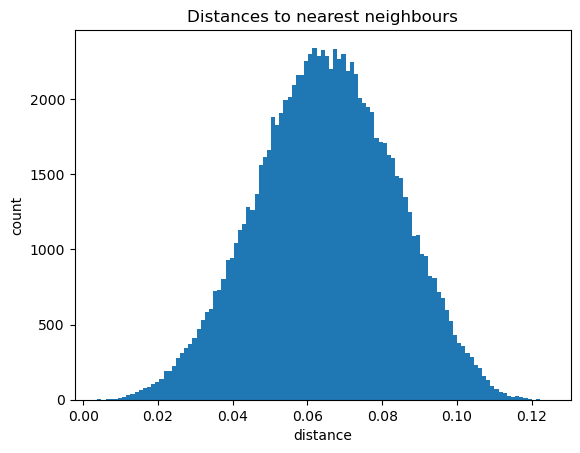

In [49]:
fig, ax = plt.subplots()
ax.hist(dist, bins=bins)
ax.set_xlabel("distance")
ax.set_ylabel("count")
ax.set_title("Distances to nearest neighbours");

In [47]:
quartiles = np.quantile(dist, [.25, .75])
iqr = quartiles[1] - quartiles[0]
h = 2 * iqr / dist.shape[0]**(1/3)
bins = int((dist.max() - dist.min()) / h)

In [48]:
bins

109

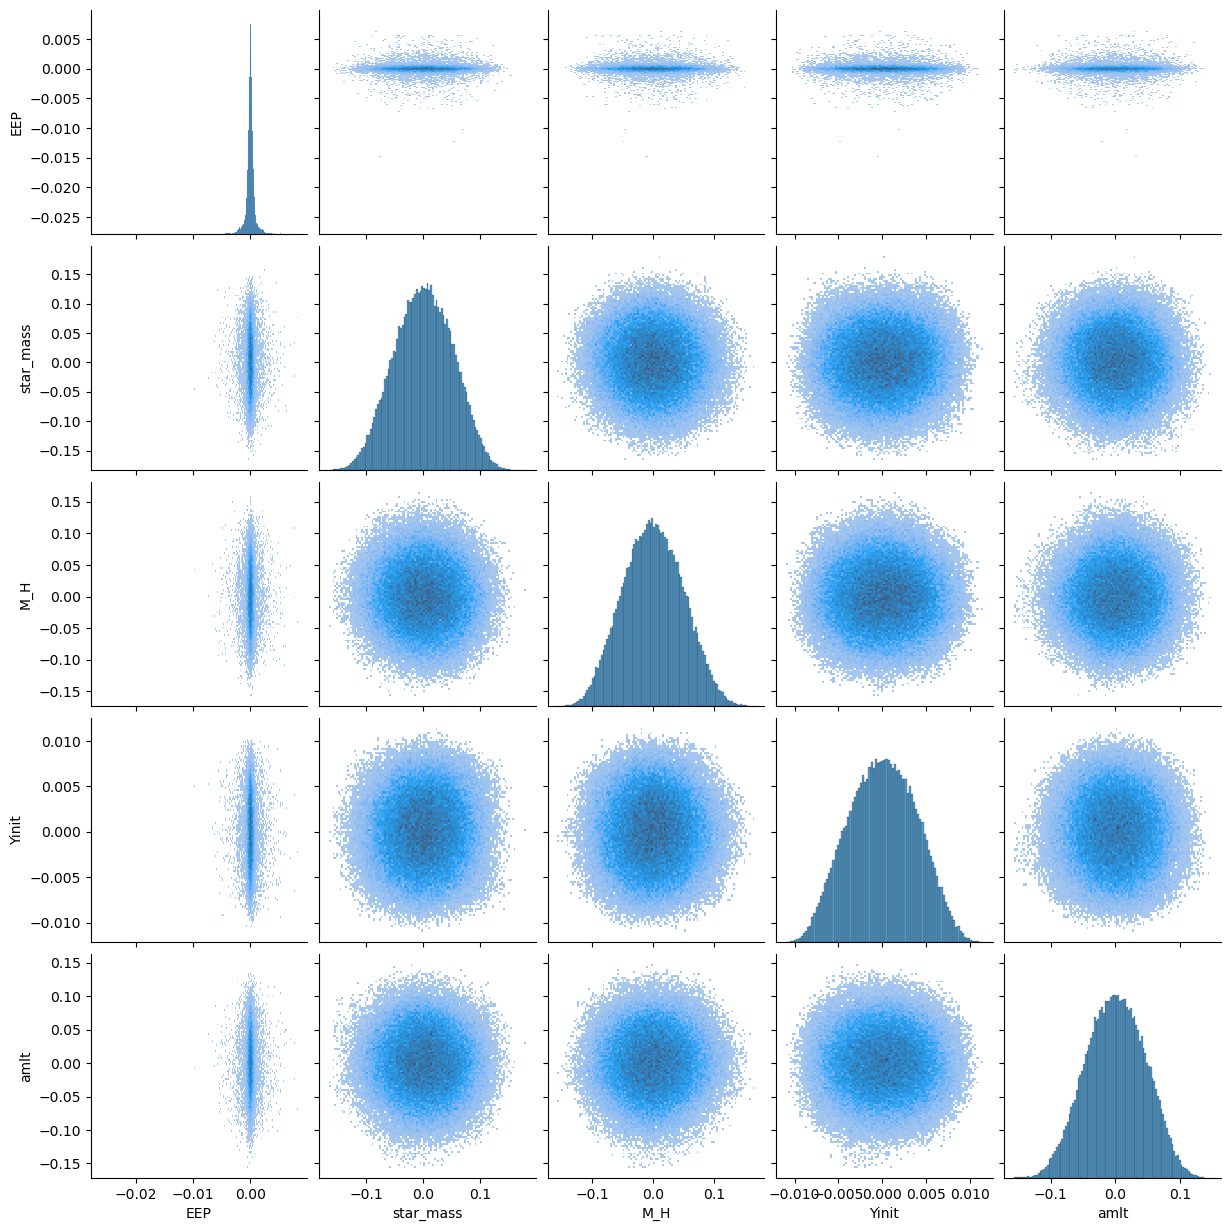

In [25]:
error = data[input_cols].iloc[i] - x
# error = train[input_cols].iloc[i] - x
sns.pairplot(error, kind="hist", diag_kind="hist");

In [26]:
q = [.01, .16, .5, .84, .99]
error.quantile(q)

,EEP,star_mass,M_H,Yinit,amlt
0.01,-0.002727,-0.111519,-0.105223,-0.007947,-0.100767
0.16,-0.000465,-0.051912,-0.050451,-0.003961,-0.046240
0.50,-0.000002,0.001294,-0.000589,0.000095,0.000897
0.84,0.000462,0.053876,0.050329,0.004104,0.048236
0.99,0.002698,0.110898,0.108083,0.008156,0.098606


In [50]:
dist.shape[0]**(1/3)

46.41588833612778

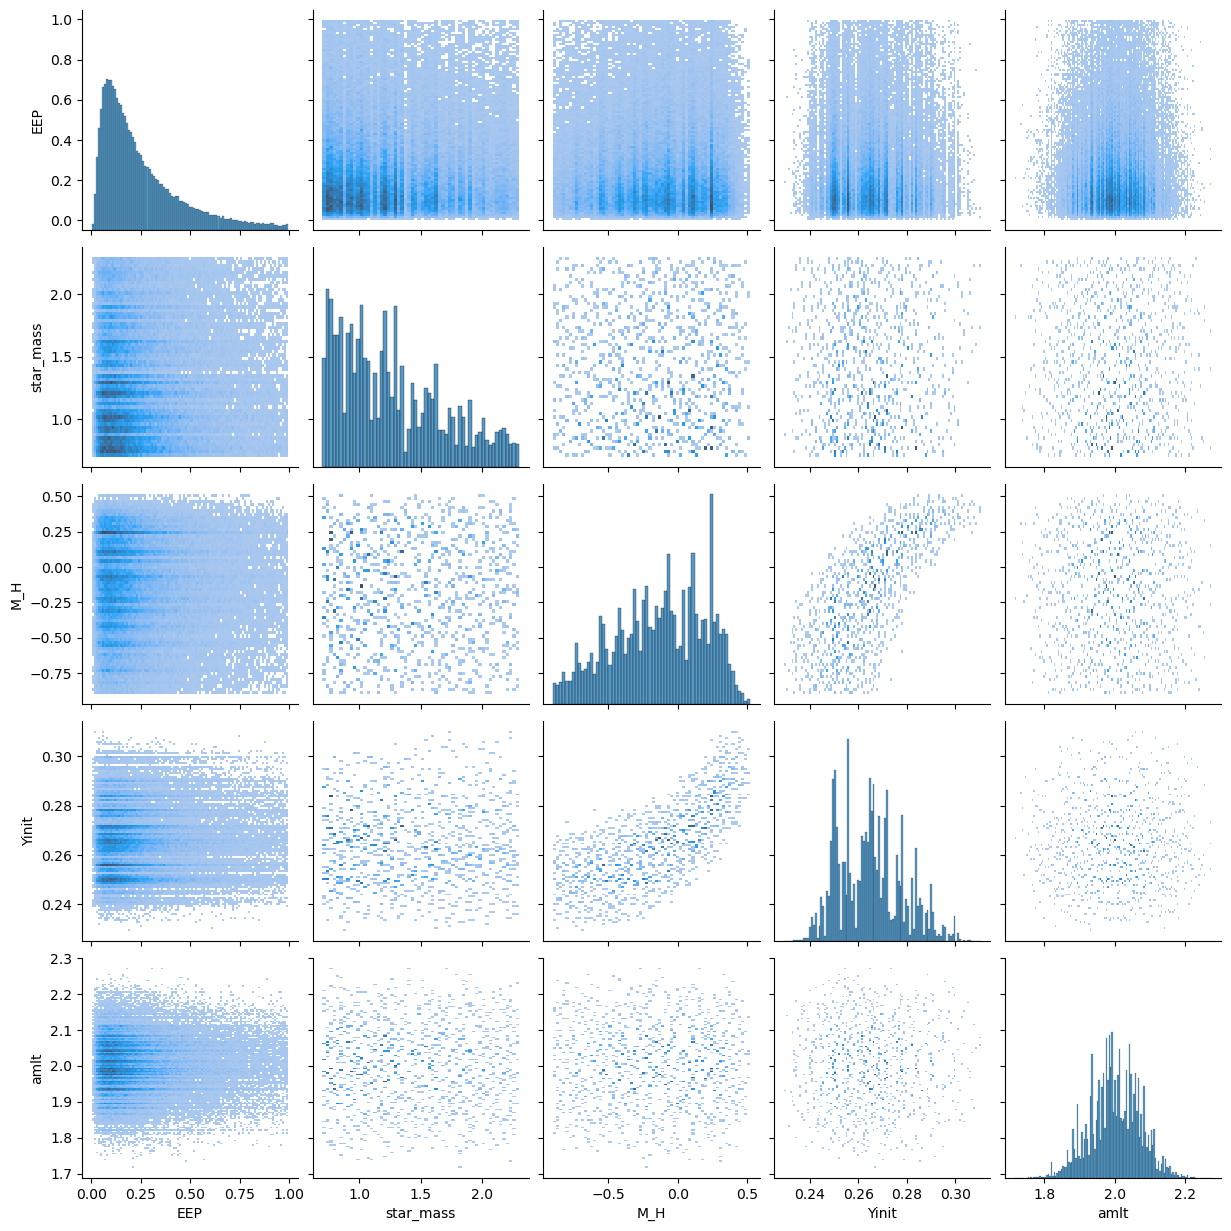

In [28]:
# sns.pairplot(train[input_cols].iloc[i], kind="hist", diag_kind="hist");
# sns.pairplot(test[input_cols].iloc[i], kind="hist", diag_kind="hist");
sns.pairplot(data[input_cols].iloc[i], kind="hist", diag_kind="hist");

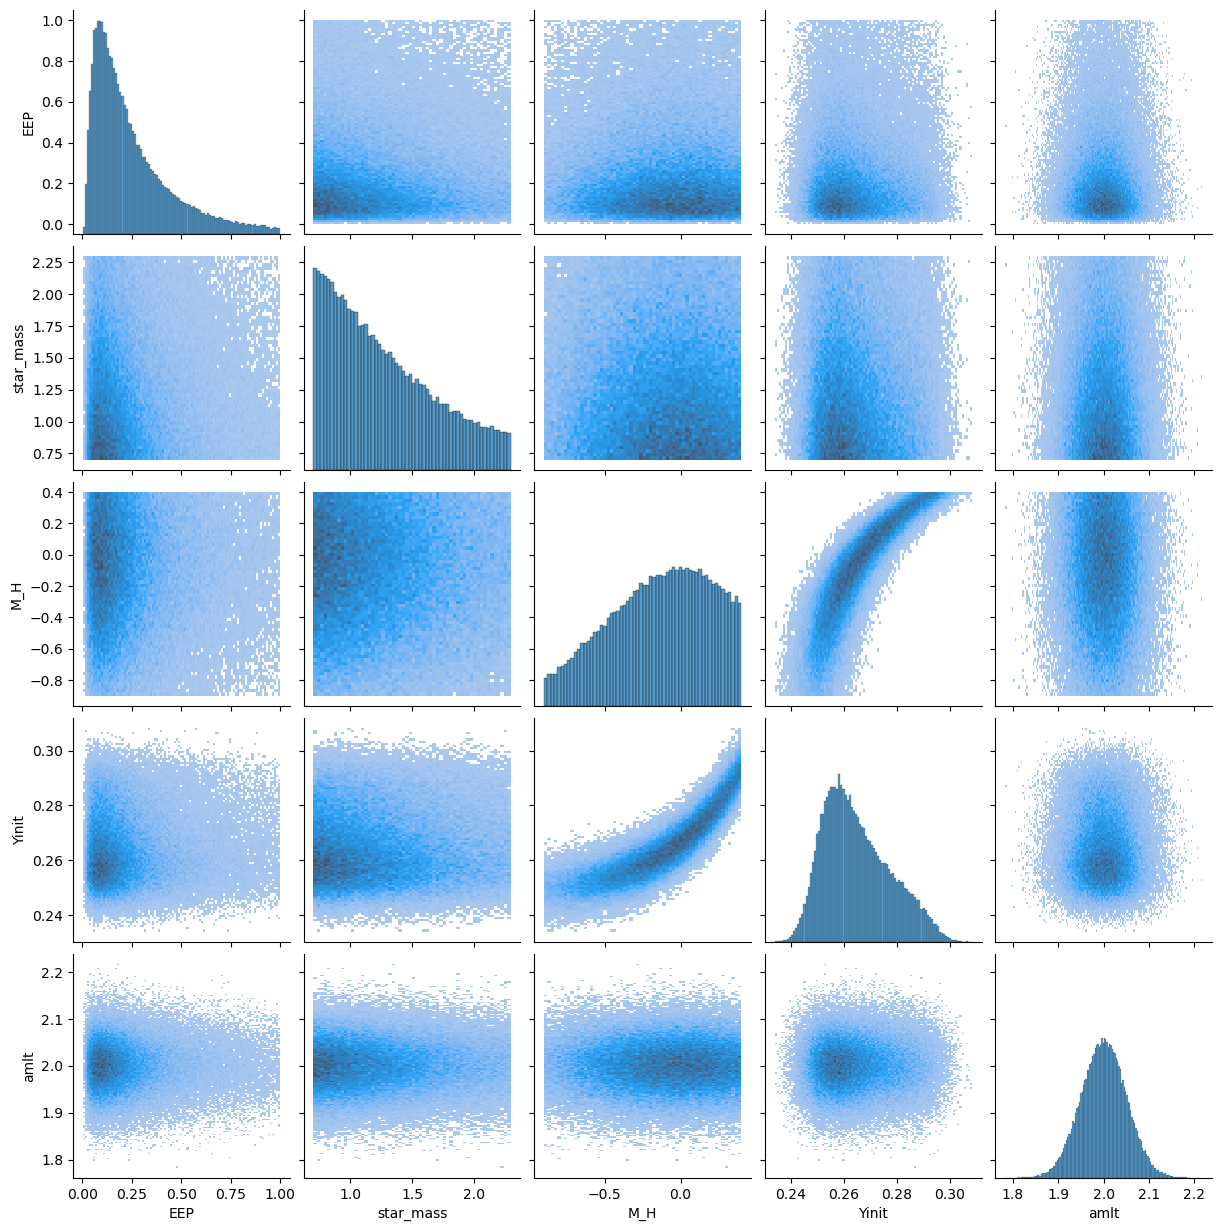

In [29]:
samples = pd.DataFrame(x, columns=input_cols)
sns.pairplot(samples, kind="hist", diag_kind="hist");

Save the nearest neighbour truths.

In [31]:
data.iloc[i].to_csv(os.path.join(directory, "truths-nearest-neighbour.csv"))

Experiment with linear interpolation.

In [26]:
from scipy.interpolate import LinearNDInterpolator
from time import time
from pympler import asizeof

In [15]:
output_cols = ["log_Teff", "log_radius"]

In [74]:
num_train = [10**i for i in range(1, 6)]
build_times = []
eval_times = []
total_time = []
sizes = []

for n in num_train:
    start_time = time()
    interpolator = LinearNDInterpolator(train[input_cols].iloc[:n], train[output_cols].iloc[:n])
    build_time = time() - start_time
    _ = interpolator(test[input_cols].iloc[0])
    eval_time = time() - build_time - start_time
    build_times.append(build_time)
    eval_times.append(eval_time)
    total_time.append(build_time + eval_time)
    sizes.append(asizeof.asizeof(interpolator))

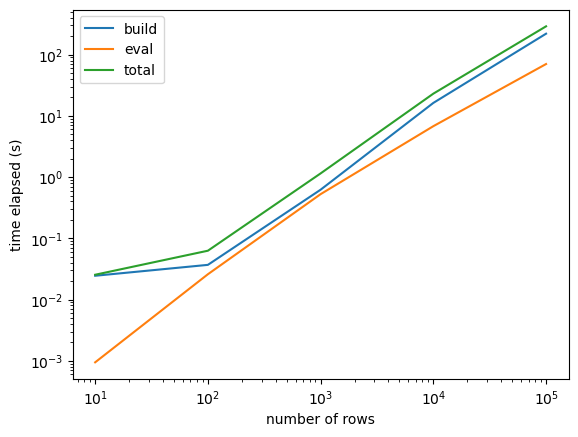

In [76]:
fig, ax = plt.subplots()
ax.plot(num_train, build_times, label="build")
ax.plot(num_train, eval_times, label="eval")
ax.plot(num_train, total_time, label="total")
ax.set_xlabel("number of rows")
ax.set_ylabel("time elapsed (s)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend();

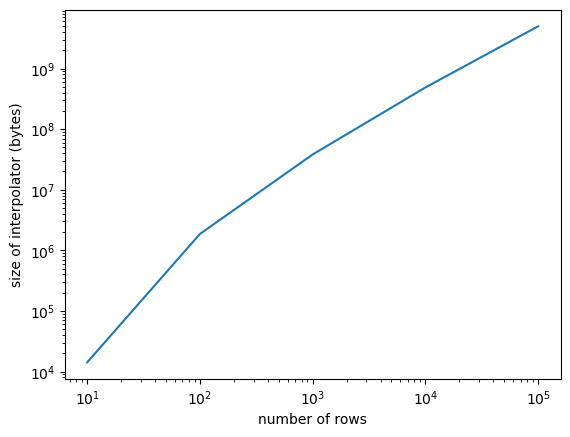

In [79]:
fig, ax = plt.subplots()
ax.plot(num_train, sizes)
ax.set_xlabel("number of rows")
ax.set_ylabel("size of interpolator (bytes)")
ax.set_xscale("log")
ax.set_yscale("log");

In [102]:
log_n = np.log(0.1*train.shape[0])
m = (np.diff(np.log(total_time[1:])) / np.diff(np.log(num_train[1:]))).max()
log_t = m * log_n + np.log(total_time[-1]) - m * np.log(num_train[-1])
print(f"Total time: {np.exp(log_t) / 60 / 60:.2f} hours")


Total time: 0.65 hours


In [103]:
m = (np.diff(np.log(sizes[1:])) / np.diff(np.log(num_train[1:]))).max()
log_s = m * log_n + np.log(sizes[-1]) - m * np.log(num_train[-1])
print(f"Size: {np.exp(log_s)*1e-9:.2f} gigabytes")

Size: 40.79 gigabytes


Experiment with inverse distance weighting for dataset $D = \{(x_i, y_i)\}_{i=1}^N$

$$f(x) = \frac{\sum_{i=1}^N w_i(x) y_i}{\sum_{i=1}^N w_i(x)}$$

where the weights are defined by the distance between $x$ and $x_i$ raised to some power,

$$w_i = d(x, x_i)^{-p}$$

The power should be similar to the number of dimensions in $x$.

The modified Shephard's method computes the weights for points a given radius $R$ around the new point.

$$w_k = \left( \frac{\max(0, R - d(x, x_k))}{R \, d(x, x_k)} \right)^p$$

Franke, R., and Nielson, G. (1980), 'Smooth Interpolation of Large Sets of Scattered Data', International Journal for Numerical Methods in Engineering, v. 15, p. 1691-1704.

In [110]:
k = 1000
dist, indices = tree.query(x_scaled, k)

In [123]:
R = dist[:, -1][:, None]
p = 2
weights = (np.maximum(0.0, R - dist) / R / dist)**p

In [124]:
x_pred = (test[input_cols].to_numpy()[indices] * weights[..., None]).sum(axis=1) / weights.sum(axis=1)[:, None]

In [125]:
err = samples - x_pred

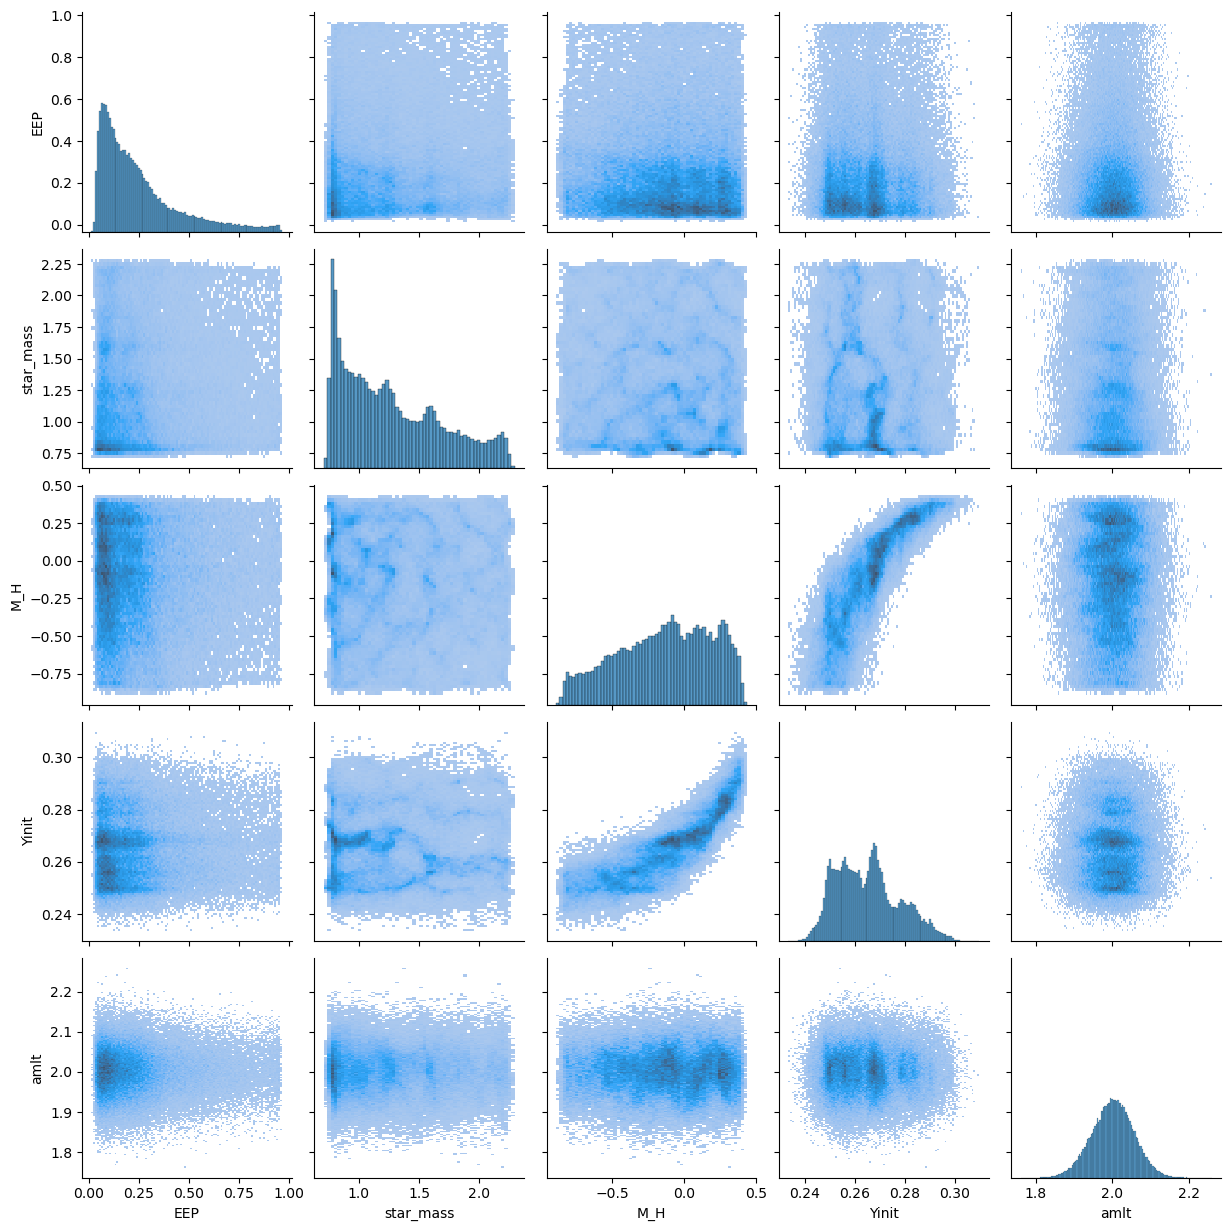

In [126]:
samples_pred = pd.DataFrame(x_pred, columns=input_cols)
sns.pairplot(samples_pred, kind="hist", diag_kind="hist");

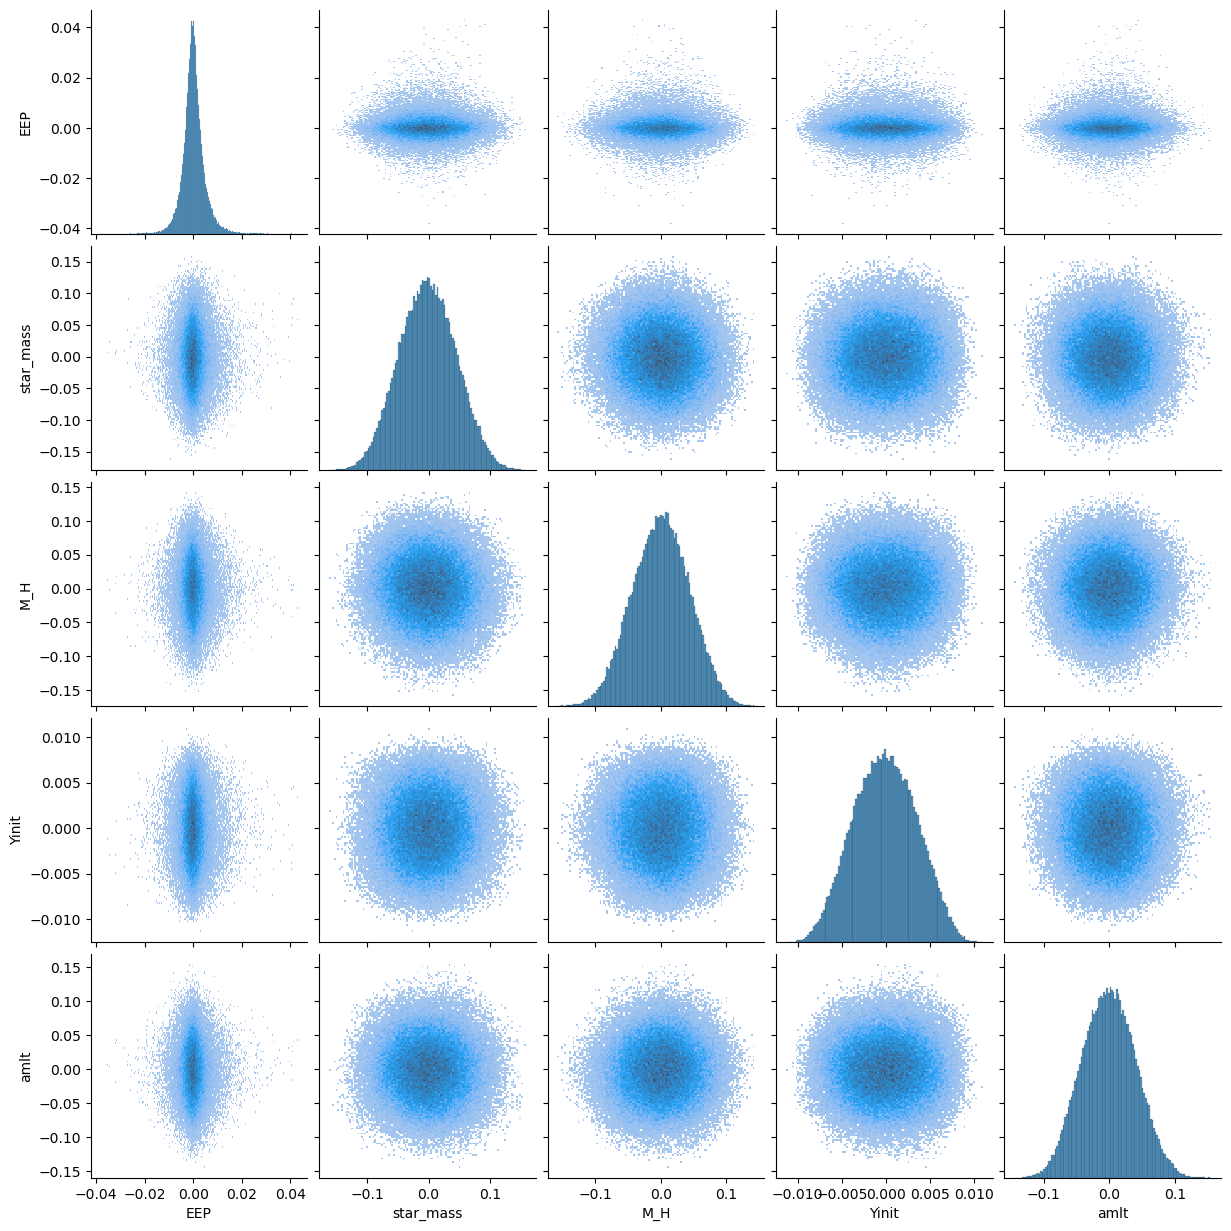

In [104]:
sns.pairplot(err, kind="hist", diag_kind="hist");